# Whether-Weather-Drives-Crime
## Analytics with Python (Matplotlib, Pandas, and API Requests)
### Data Analytics Bootcamp - Project 1 - Group 7

#### Team Members
Minna Wu<br>
Tim Sutherland<br>
Wenjie Shao<br>
Gobind Singh<br>

#### Project Description 
We are interested in seeing whether there is a correlation weather and the number of major crimes commited. For this project, we decided to look at just the City of Toronto.
 
#### Research Questions to Answer 
Is there a correlation between weather and major crimes?<br>
- Temperature vs. crime
- Weekend or weekday vs. crime
- Precipitation vs. crime
- Moon phase vs. crime

#### Data Sets to be Used
2 APIs:
- MCI (Major Crime Indicators) 2014-2017 (http://data.torontopolice.on.ca/datasets/mci-2014-to-2017/geoservice)
- World Weather Online (https://www.worldweatheronline.com/developer/premium-api-explorer.aspx)

#### Rough Breakdown of Tasks
Minna Wu: Pulling and cleaning of Weather Data<br>
Wenjie Shao: Pulling and cleaning of Crime Data<br>
Gobind Singh:  Preparing data using Pandas<br>
Tim Sutherland: Plotting charts and final analysis write-up<br>

In [88]:
# Dependencies
import requests
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import math
import seaborn as sb

## Pulling and Cleaning Crime Data

In [15]:
# Set up query url
base_url = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/MCI_2014_2017/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"

In [34]:
# Prepare lists for storing crime data
date_of_crime = []
day_of_week_crime = []
crime_type_list = []

# Setup offset variable (2000 records max in each pull but >130,000 records in total)
total_pulls = math.ceil(131073/2000) # 66

for pull_num in range(total_pulls):
    
    offset_num = pull_num*2000
    url = f"{base_url}&resultOffset={offset_num}"
    crime_data = requests.get(url).json()
    
    for i in range(len(crime_data['features'])):
        
        # Convert occurrence date to match weather date
        day = str(crime_data['features'][i]['attributes']['occurrenceday'])
        if day.isnumeric():
            if int(day) < 10:
                formatted_day = '0' + str(day)
            else:
                formatted_day = str(day)
        else: # if date record is missing
            continue

        month = crime_data['features'][i]['attributes']['occurrencemonth']
        month_dict = {'January':'01', 'February':'02', 'March':'03', 'April':'04', 'May':'05',\
                    'June':'06', 'July':'07', 'August':'08', 'September':'09', 'October':'10',\
                    'November':'11', 'December':'12'}
        formatted_month = month_dict[month]
        year = crime_data['features'][i]['attributes']['occurrenceyear']

        # Exclude dates outside of 2014 to 2017 range (since MCI 2014-2017 has some records prior to 2014)
        if year < 2014:
            continue

        formatted_date = f"{year}-{formatted_month}-{formatted_day}"
        #print(formatted_date)
        date_of_crime.append(formatted_date)

        # Weekday
        weekday = crime_data['features'][i]['attributes']['occurrencedayofweek']
        day_of_week_crime.append(weekday)

        # Type of Crime (MCI)
        crime_type = crime_data['features'][i]['attributes']['MCI']
        crime_type_list.append(crime_type)

# Store lists into a dataframe
crime_df = pd.DataFrame({'Date': date_of_crime,
                         'Day_of_week': day_of_week_crime,
                         'Type': crime_type_list})

crime_df.head()

,Date,Day_of_week,Type
0,2014-01-25,Saturday,Assault
1,2014-01-25,Saturday,Assault
2,2014-01-25,Saturday,Assault
3,2014-01-25,Saturday,Break and Enter
4,2014-01-25,Saturday,Break and Enter


In [35]:
crime_df.count()

Date           130167
Day_of_week    130167
Type           130167
dtype: int64

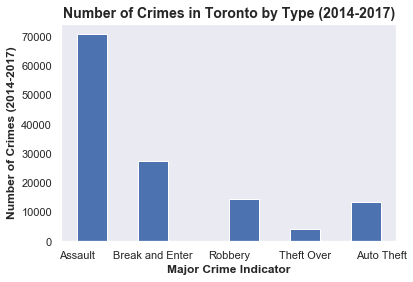

In [55]:
# Histogram by Type of Crime
sb.set()
plt.hist(crime_type_list)
plt.title('Number of Crimes in Toronto by Type (2014-2017)', fontsize = 14, fontweight = 'bold')
plt.xlabel('Major Crime Indicator', fontweight = 'bold')
plt.ylabel('Number of Crimes (2014-2017)', fontweight = 'bold')
plt.grid()
plt.show()

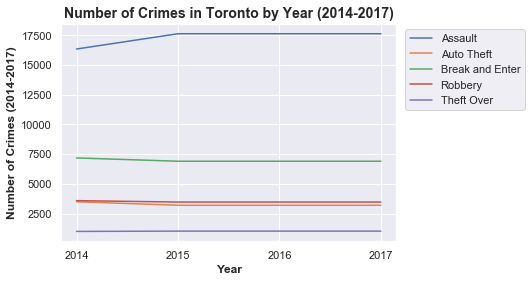

,2014,2015,2016,2017
Type,,,,
Assault,16339,17624,17624,17624
Auto Theft,3488,3194,3194,3194
Break and Enter,7175,6898,6898,6898
Robbery,3583,3464,3464,3464
Theft Over,993,1017,1017,1017


In [147]:
# Prepare data for plotting number of crimes by year
crimes_2014 = crime_df[crime_df.Date.str.startswith('2014')] # 31578 records
crimes_2015 = crime_df[crime_df.Date.str.startswith('2015')] # 32197 records
crimes_2016 = crime_df[crime_df.Date.str.startswith('2016')] # 32601 records
crimes_2017 = crime_df[crime_df.Date.str.startswith('2017')] # 33791 records
num_crimes_2014 = crimes_2014.groupby('Type').count()['Date'] 
num_crimes_2015 = crimes_2015.groupby('Type').count()['Date']
num_crimes_2016 = crimes_2016.groupby('Type').count()['Date']
num_crimes_2017 = crimes_2017.groupby('Type').count()['Date']
crime_type_by_year_df = pd.DataFrame({'2014': num_crimes_2014,
                                     '2015': num_crimes_2015,
                                     '2016': num_crimes_2015,
                                     '2017': num_crimes_2015})

# Create Line Plot of the Number of Crimes By Year
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(crime_type_by_year_df.T)
plt.title('Number of Crimes in Toronto by Year (2014-2017)', fontsize = 14, fontweight = 'bold')
plt.xlabel('Year', fontweight = 'bold')
plt.ylabel('Number of Crimes (2014-2017)', fontweight = 'bold')
leg = plt.legend(crime_type_by_year_df.index, loc = 'upper right')

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend
xOffset = 0.4
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

plt.show()
crime_type_by_year_df

In [5]:
# WWO apikey
apikey = "56b161f544224f85b0e180450181711"

In [68]:
# Prepare lists for storing weather data
date_list = []
temp_list = []
moon_list = []
rain_list = []
years_of_interest = ['2014', '2015', '2016', '2017']
months_of_interest = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
last_day_of_month = ['31', '28', '31', '30', '31', '30', '31', '31', '30', '31', '30', '31']

for year in years_of_interest:
    for i in range(12):
        
        # Prepare start and end dates for query
        start_date = f"{year}-{months_of_interest[i]}-01"
        end_date = f"{year}-{months_of_interest[i]}-{last_day_of_month[i]}"
        
        # Prepare url (24hr average)
        weather_url = f"http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={apikey}&q=Toronto&format=json&date={start_date}&enddate={end_date}&tp=24"
        
        # Request and store json data
        #data = requests.get(weather_url).json()
        
        for day in range(len(data['data']['weather'])):
            # Date
            date_list.append(data['data']['weather'][day]['date'])

            # Temperature
            temp_list.append(data['data']['weather'][day]['hourly'][0]['tempC'])

            # Precipitation
            rain_list.append(data['data']['weather'][day]['hourly'][0]['precipMM'])

            # Moon_phase
            moon_list.append(data['data']['weather'][day]['astronomy'][0]['moon_phase'])

# Store lists into a dataframe
weather_df = pd.DataFrame({'Date': date_list,
                          'Temp': temp_list,
                          'Precip': rain_list,
                          'Moon Phase': moon_list})

weather_df.head()

,Date,Temp,Precip,Moon Phase
0,2014-01-01,-8,0.9,Waning Crescent
1,2014-01-02,-13,3.1,Waning Crescent
2,2014-01-03,-14,0.2,Waning Crescent
3,2014-01-04,2,0.5,Waning Crescent
4,2014-01-05,2,12.5,Waning Crescent


In [67]:
# Test Code Block
start_date = '2014-07-01'
end_date = '2014-07-31'
weather_url = f"http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={apikey}&q=Toronto&format=json&date={start_date}&enddate={end_date}&tp=24"
data = requests.get(weather_url).json()
#pprint(data)
print(len(data['data']['weather']))

# Date
print(data['data']['weather'][0]['date'])
# Temperature
print(data['data']['weather'][0]['hourly'][0]['tempC'])
# Precipitation
print(data['data']['weather'][0]['hourly'][0]['precipMM'])
# Moon_phase
print(data['data']['weather'][0]['astronomy'][0]['moon_phase'])

31
2014-07-01
31
1.2
New Moon
